#### ML HW3 Xinmeng Zhang

In [2]:
# library for dataframes
import pandas as pd

# scientific computing libraries
import numpy as np
import numpy.random as rn
import scipy.stats as st
from collections import Counter

# plotting libraries
import matplotlib.pyplot as plt

import seaborn as sns

# data
data = np.load('FilteredRecording.npy')

### Question 2 Neural Data

#### (a) 
Threshold the data at 95 and find the contiguous segments of data above that
level. For each initial time point t of a contiguous segment extract a segment of
80 time points $X(t-40 : t + 40)$. You should get about $n \sim 18,000$ length 80
curves. Plot some of them to get a sense of your data. Arrange these curves in
an $n \times 80$ array Z.

In [2]:
segment_len = 40
threshold = np.percentile(data, 95)
seg_starts = np.where(data > threshold)[0]  # find indices where data is above threshold
n_segs = len(seg_starts)

# extract segments around each start point
segments = []
for start in seg_starts:
    if start >= segment_len & start <= len(data)-segment_len:
        segments.append(data[start-segment_len:start+segment_len])


In [3]:
# plot some example segments
def plot_seg_exmaple(data):
    Z = np.vstack(data)
    fig, axs = plt.subplots(3, 3, figsize=(8, 6))
    for i in range(3):
        for j in range(3):
            idx = np.random.randint(0, len(data))
            axs[i, j].plot(Z[idx])
    plt.show()

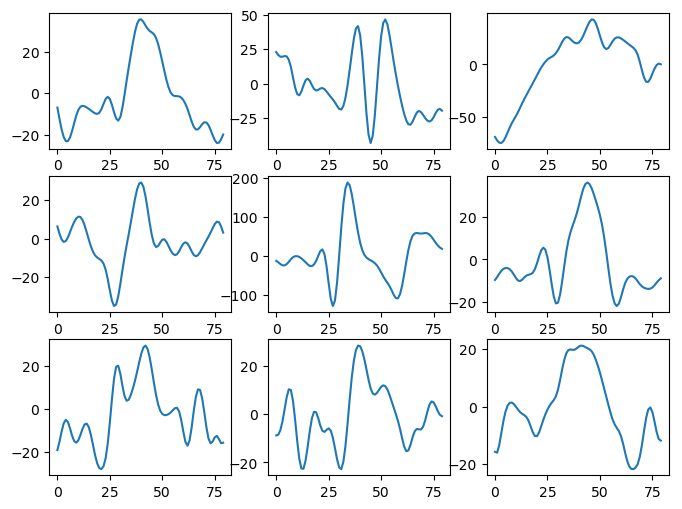

In [4]:
plot_seg_exmaple(segments)

#### (b)
We'd like to cluster these curves but the problem is that they are not aligned.
One way to align them is to match their maxima. For each curve $Z[i,:]$ find its
time ti of maximal value and extract a shorter curve of length 50 centered at ti.
(If ti is too close to the beginning or the end just drop that sample.) This will
yield a new array Y of dimension $m \times 50$, with m a bit smaller than n. All curves
in Y have their maximum at time point 25.

In [5]:
def find_50_around_maxima(data):
    n = len(data)
    Y = np.zeros((n, 50))
    for i in range(n):
        curve = data[i]
        ti = np.argmax(curve)  # index of the maximum value of the curve
        if ti >= 25 and ti <= len(curve) - 25:
            Y[i, :] = curve[ti-25:ti+25]  # Extract the segment

    # Remove curves that were too close to the beginning or end
    Y = Y[~np.all(Y == 0, axis=1)]
    return Y

In [6]:
seg50 = find_50_around_maxima(segments)

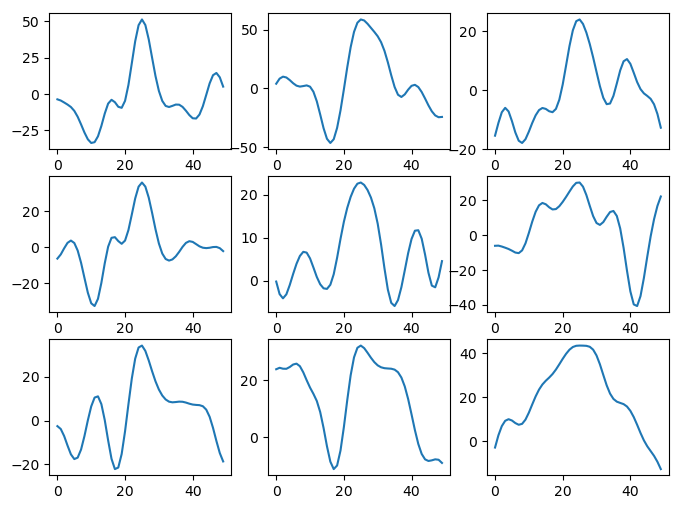

In [7]:
plot_seg_exmaple(seg50)

#### (c)
Now perform Kmeans clustering on these curves, with 2,3 and 4 clusters. Plot
the cluster means and the curves assigned to each cluster.

In [9]:
from sklearn.cluster import KMeans


# define the number of clusters
k_list = [2, 3, 4]

def do_kmeans(data, k):
    # create KMeans object with the desired number of clusters
    kmeans = KMeans(n_clusters=k, random_state=0)

    # fit the KMeans object to the data
    kmeans.fit(data)

    # get the cluster labels and cluster means
    labels = kmeans.labels_
    cluster_means = kmeans.cluster_centers_

    return labels, cluster_means

In [16]:
def plot_seg_cluster(num_clusters, cluster_means, labels, data, rangeOfcurve):
    color_mean = ['thistle', 'yellowgreen', 'orange', 'deeppink']
    color = ['lightskyblue', 'navy', 'darkgoldenrod', 'red']

    for j in range(rangeOfcurve):
        plt.plot(data[j], linewidth=0.5, alpha=0.5, color = color[labels[j]])
    for i in range(num_clusters):
        plt.plot(cluster_means[i], linewidth=5, color = color_mean[i])  # cluster mean
    plt.show()

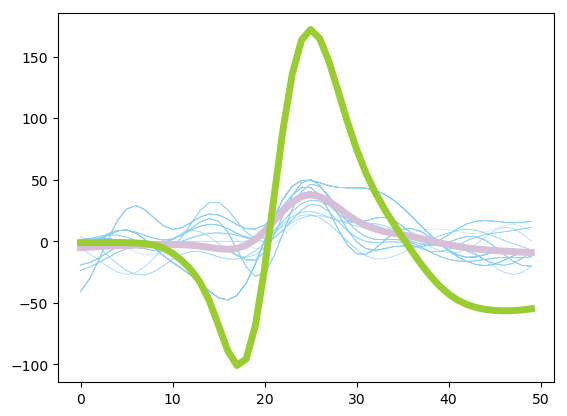

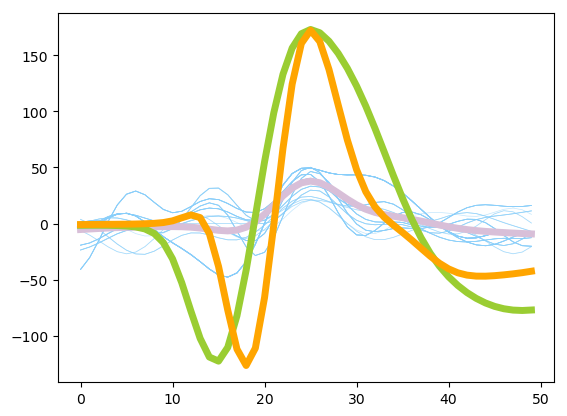

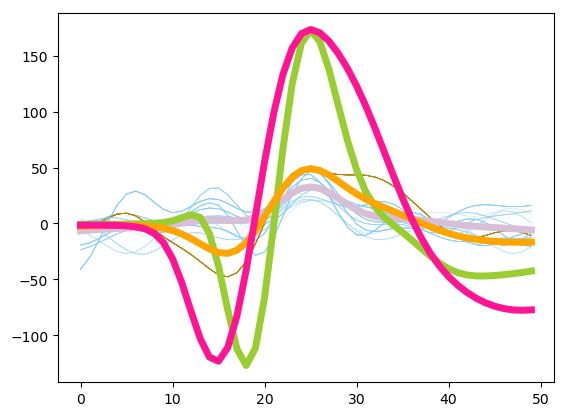

In [17]:
rangeOfcurve = 60
Kmeanscluster_means_all = []
for i in k_list:
    num_clusters = i

    Kmeanslabels, Kmeanscluster_means = do_kmeans(seg50, num_clusters)
    Kmeanscluster_means_all.append(Kmeanscluster_means)
    plot_seg_cluster(num_clusters, Kmeanscluster_means, Kmeanslabels, seg50, rangeOfcurve)

#### (d)
A different way to cluster is to first perform dimensionality reduction using PCA
on the first 2 principal components. Write your own PCA routine (don't use
the one supplied by python). Of course you can use the python or scipy eigen
function. Plot the projection of the data onto the first two principal components.
(Use very small dots in order to better see the structure of the data.)

In [13]:
def pca(X):
    # Calculate the covariance matrix of X
    cov = np.cov(X.T)
    
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    
    # Sort the eigenvectors by descending order of eigenvalues
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Calculate the projection of X onto the first two principal components
    Z = X @ eigenvectors[:, :2]
    
    return Z, eigenvalues, eigenvectors

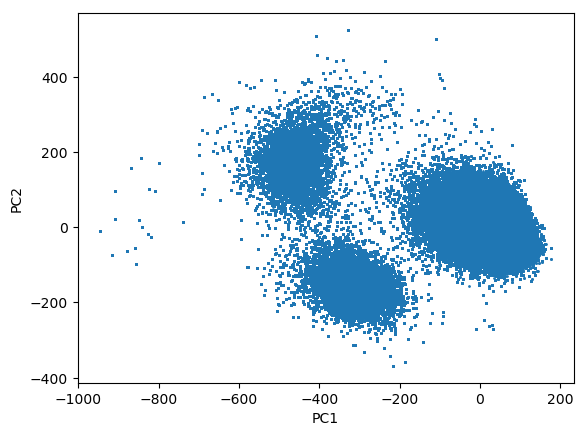

In [19]:
# Center the data
Yc = seg50 - seg50.mean(axis=0)

# Perform PCA
Z, eigenvalues, eigenvectors = pca(Yc)

# Plot the projection of the data onto the first two principal components
plt.scatter(Z[:, 0], Z[:, 1], s=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


#### (e)
Now cluster the data using Kmeans using the 2d projections into 2,3, and 4
clusters. Plot the data with their cluster assignments in color.

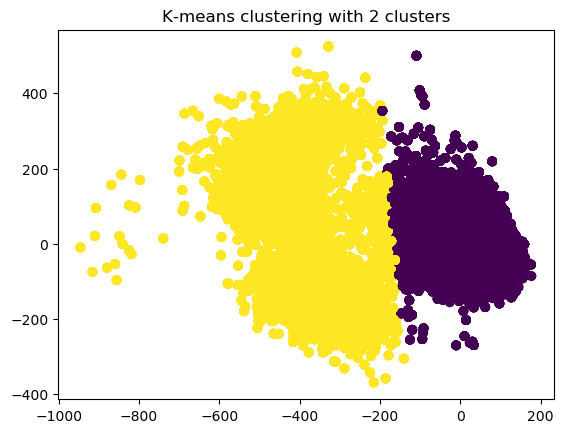

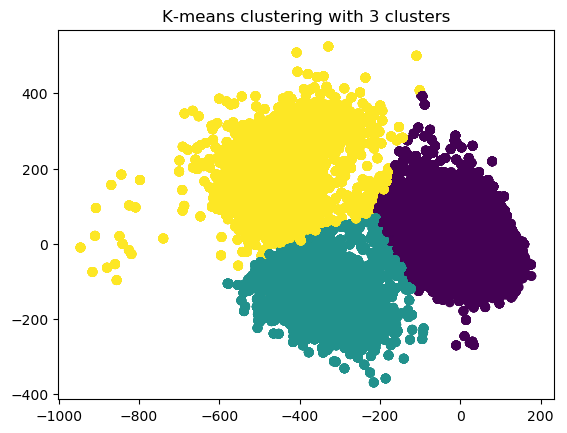

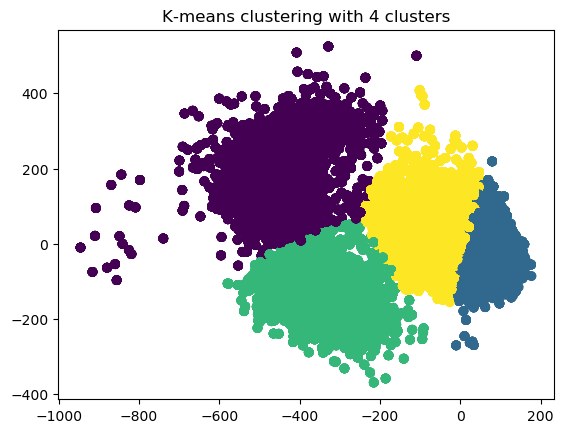

In [28]:
# Project the data onto the first two principal components
Z_pca = Yc.dot(eigenvectors[:, :2])

for n_clusters in range(2, 5):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(Z_pca)
    cluster_labels = kmeans.labels_
    
    # Plot the data with color-coded clusters
    plt.scatter(Z_pca[:, 0], Z_pca[:, 1], c=cluster_labels)
    plt.title(f"K-means clustering with {n_clusters} clusters")
    plt.show()

#### (f)
Use the corresponding cluster assignments to produce mean curves for each cluster. Compare these mean curves to the ones you got clustering the curves directly.

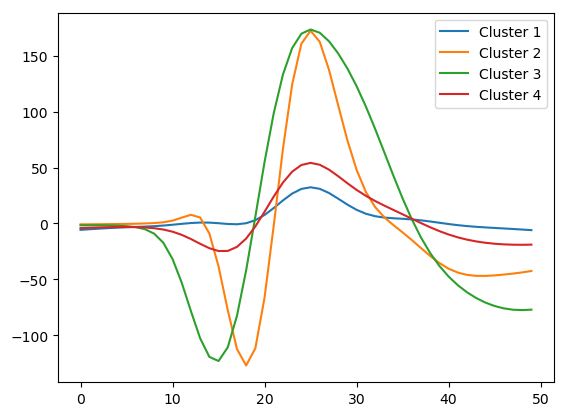

In [31]:

kmeans_model = KMeans(n_clusters=4)
kmeans_model.fit(Z_pca)

# Get the cluster assignments for each curve
cluster_labels = kmeans_model.labels_

# Initialize an empty list to store the curves for each cluster
cluster_curves = [[] for _ in range(n_clusters)]

# Group the curves by their cluster assignments
for i, label in enumerate(cluster_labels):
    cluster_curves[label].append(seg50[i])

# Compute the mean curve for each cluster
mean_curves = [np.mean(cluster, axis=0) for cluster in cluster_curves]

# Plot the mean curves
for i, curve in enumerate(mean_curves):
    plt.plot(curve, label=f"Cluster {i+1}")

plt.legend()
plt.show()


We see that it's pretty similar to what we got in 2(c)

### Question 3 Handwritten digits

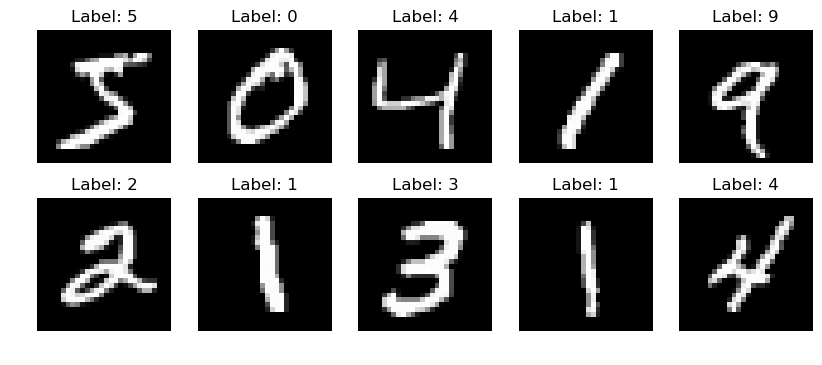

In [3]:
# Load the data and labels
mnist = np.load('MNIST_data.npy') / 255.0
mnist_labels = np.load('MNIST_labels.npy')

# Define a function to display a few digits
def show_digits(digits, labels):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(2):
        for j in range(5):
            ax[i, j].imshow(digits[i*5+j].reshape(28, 28), cmap='gray')
            ax[i, j].axis('off')
            ax[i, j].set_title(f'Label: {labels[i*5+j]}')
    plt.show()

# Display a few digits
examples = mnist[:10]
show_digits(examples, mnist_labels[:10])


#### (a) Extract principal components.
Using the code you wrote in the previous problem PCA to extract the principal
components of the training data. Display the first 10 principal components as
images.


In [4]:
from sklearn.model_selection import train_test_split
mnist_train, mnist_test, train_labels, test_labels = train_test_split(mnist, mnist_labels, test_size=0.2, random_state=42)

d:\anaconda3\envs\cse160\lib\site-packages\ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


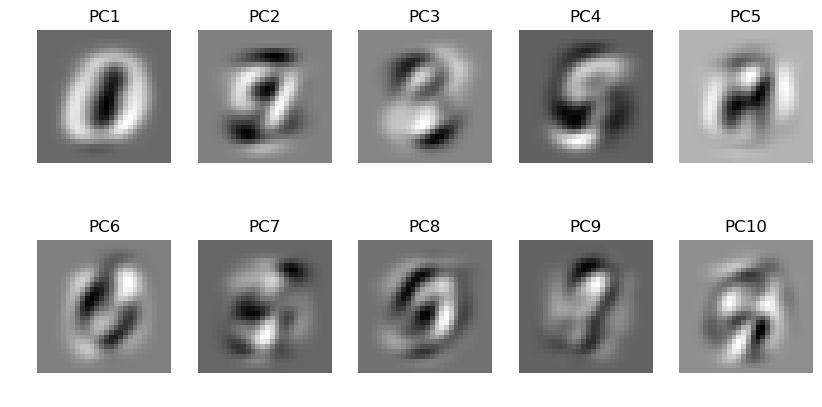

In [5]:
from PIL import Image

# PCA function
def PCA(X, k):
    # center data
    X_centered = X - np.mean(X, axis=0)
    
    # compute covariance matrix
    cov_matrix = np.cov(X_centered.T)
    
    # compute eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # sort eigenvectors by eigenvalues
    idx = eigenvalues.argsort()[::-1]
    eigenvectors = eigenvectors[:,idx]
    
    # return first k eigenvectors
    return eigenvectors[:,:k], eigenvalues

# extract first 10 principal components
pcs,eigenvalues = PCA(mnist_train, 10)
pcs = pcs.astype('float') / 255.0


# create a figure with 2 rows and 5 columns of subplots
fig, axs = plt.subplots(2, 5, figsize=(10, 5))

# iterate through the first 10 principal components and display each as an image
for i, ax in enumerate(axs.flatten()):
    pc_image = pcs[:, i].reshape(28, 28)
    pc_image = (pc_image - np.min(pc_image)) / (np.max(pc_image) - np.min(pc_image)) * 255
    ax.imshow(pc_image, cmap='gray')
    ax.set_title(f'PC{i+1}')
    ax.axis('off')

# display the figure
plt.show()


#### (b) Plot variance
Plot the variance of all of the principal components - this corresponds to the
eigenvalues. This should be monotonically decreasing.


d:\anaconda3\envs\cse160\lib\site-packages\matplotlib\cbook\__init__.py:1365: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


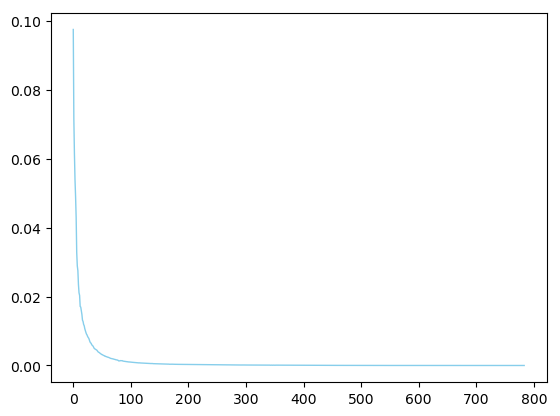

In [6]:
pcs,eigenvalues = PCA(mnist_train, len(mnist_train))

var_PC = eigenvalues / np.sum(eigenvalues)
plt.plot(var_PC, linewidth=1, color = 'skyblue')  # cluster mean
plt.show()

#### (c) Dimension reduction
Take a data point in the test data set and project it onto the first m principal components (remember to first subtract the mean). Then, transform that m-length
vector back into a 784-length vector and display it as an image (add back the
mean). Repeat this for several different values of m. Also, try it on different data
points. Describe the results qualitatively. Does it give an accurate representation
of the images? How do the results depend on m? Can you describe what the top
principal components are capturing?

d:\anaconda3\envs\cse160\lib\site-packages\ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  


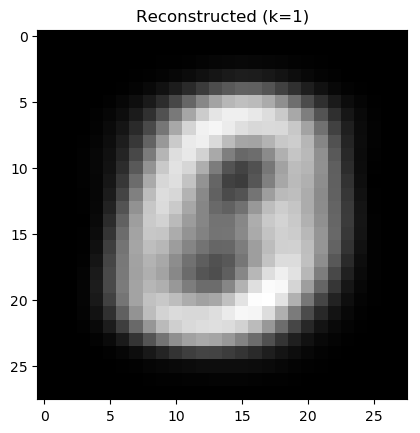

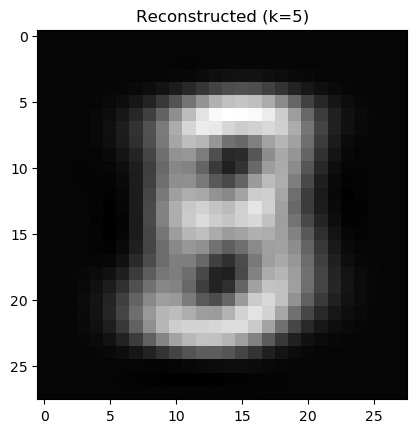

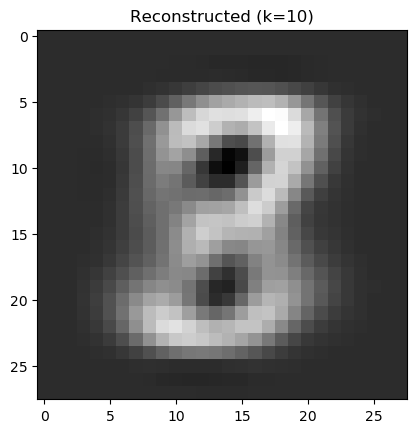

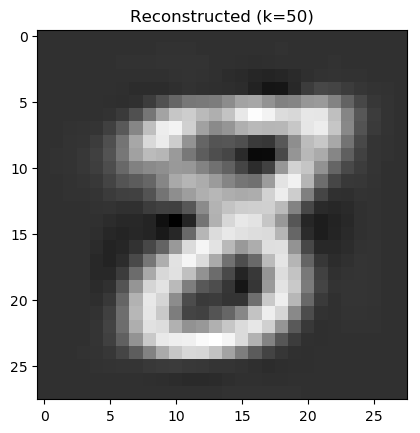

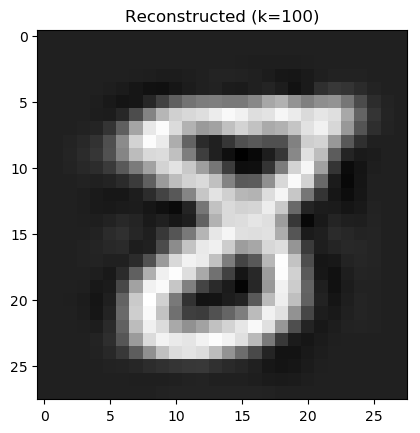

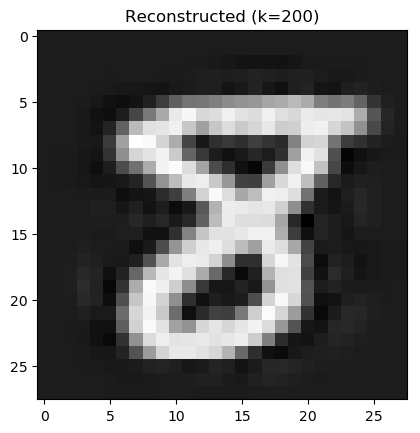

In [9]:
# choose a data point from the test set
i = 0
data_point = mnist_test[i]
data_point_centered = data_point - np.mean(mnist_train, axis=0)

for k in [1, 5, 10, 50, 100, 200]:
    # extract first k principal components
    pcs,values = PCA(mnist_train, k)
    
    # project data point onto principal components
    projected_point = pcs.T.dot(data_point_centered)
    
    # transform back to 784-length vector and add back the mean
    reconstructed_point = pcs.dot(projected_point) + np.mean(mnist_train, axis=0)
    
    reconstructed_point = reconstructed_point.astype('float') / 255.0

    # plot the reconstructed data point
    plt.imshow(reconstructed_point.reshape(28, 28), cmap='gray')
    plt.title(f'Reconstructed (k={k})')
    plt.show()

#### (d) k-means
Now use k-means to perform unsupervised clustering of the digit data, and try to assess how well the clusters capture the structure of the data. Do not produce more than 50 clusters. Show the centers of the clusters. To evaluate how closely
the clusters capture the structure of the data, associate each cluster with the majority label. 

Construct plots showing samples of the digits from each cluster, and comment on
how well the clusters respect the true digit labels.

In [7]:
def pca1(X):
    X_mean = np.mean(X, axis=0)
    X = X - X_mean
    cov = np.cov(X.T)
    U, S, V = np.linalg.svd(cov)
    components = np.dot(X, V.T)

    return U, S, V, components

In [10]:
U, S, V, output = pca1(mnist_train)
num_clusters = 10

labels, cluster_means = do_kmeans(mnist_train, num_clusters)

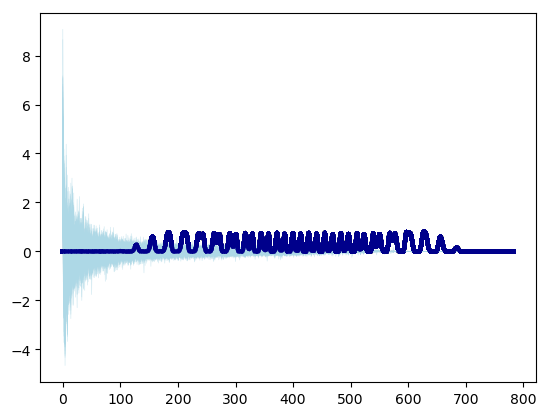

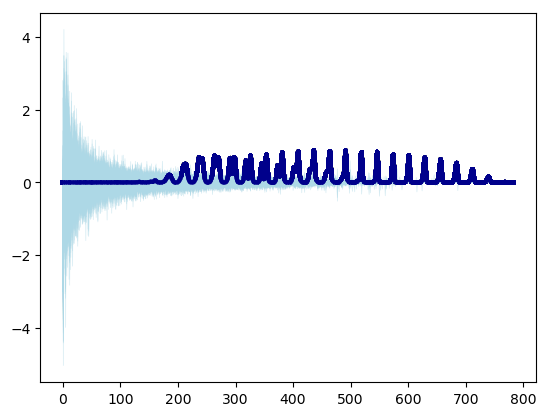

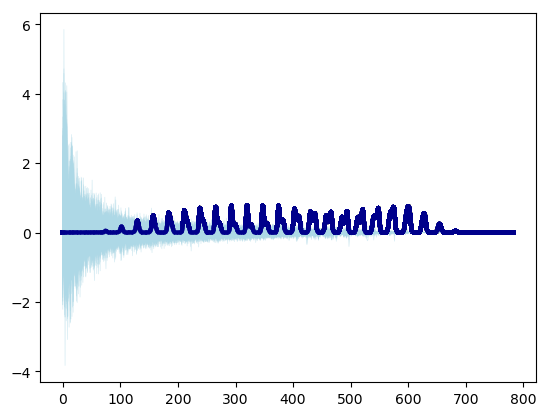

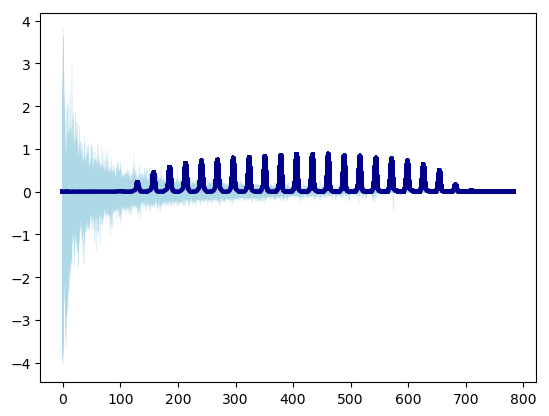

In [11]:
for i in range(num_clusters):
    for j in range(100):
        plt.plot(output[labels==i][j], linewidth=0.5, alpha=0.5, color = 'lightblue')
        plt.plot(cluster_means[i], linewidth=3, color = 'darkblue')
    plt.show()

#### (e) Bernoulli mixtures
Binarize the dataset by thresholding each pixel value at $\tau = 0.5$. Implement the
EM algorithm from the previous problem with $M = 10, 20$

In [ ]:
def EM_algorithm_binarized(X, num_components, num_iterations=100):
    """
    Runs the EM algorithm on binarized data X to fit a mixture of Bernoulli distributions.
    Returns the learned parameters pi, mu, and sigma.
    """
    num_samples, num_features = X.shape
    
    # Initialize w matrix randomly
    w = np.random.rand(num_features, num_components)
    w /= w.sum(axis=1)[:, np.newaxis]
    
    # Run EM algorithm
    for i in range(num_iterations):
        # E-step: compute responsibilities
        z = X.dot(w)
        z /= z.sum(axis=1)[:, np.newaxis]
        
        # M-step: update parameters
        w = z.sum(axis=0) / num_samples
        mu = z.T.dot(X) / z.sum(axis=0)[:, np.newaxis]
        mu = (mu + 1) / 2  # Avoid probabilities of 0 or 1
        
        # Print progress
        if (i+1) % 10 == 0:
            print(f"Iteration {i+1} complete")
        
    # Return learned parameters
    return w, mu

# Binarize the data
train_X_binarized = (mnist_train > 0.5).astype(int)
test_X_binarized = (mnist_test > 0.5).astype(int)

# Run EM algorithm with M = 10 and M = 20
pi10, mu10 = EM_algorithm_binarized(train_X_binarized, num_components=10)
pi20, mu20 = EM_algorithm_binarized(train_X_binarized, num_components=20)

# Plot the mu matrix for each component
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(12, 3))
for i in range(10):
    axes[0, i].imshow(mu10[:, i].reshape(28, 28), cmap='gray')
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])
    
for i in range(20):
    axes[1, i].imshow(mu20[:, i].reshape(28, 28), cmap='gray')
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])
    
plt.show()
